Importing all necessary stuff.



In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np
import time
import random

Loading cifar10 dataset and printing first 10 example with corresponding label names.

frog


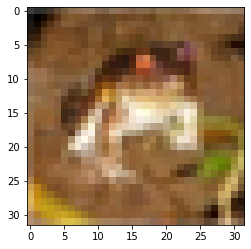

truck


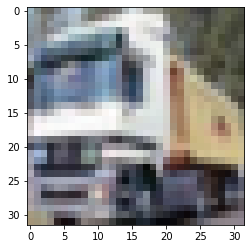

truck


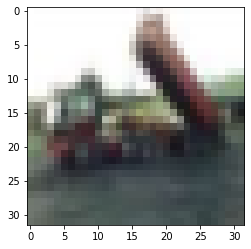

deer


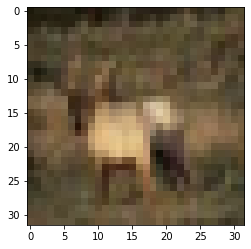

automobile


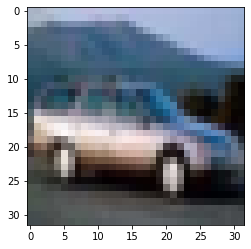

automobile


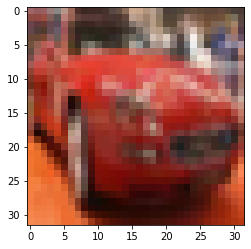

bird


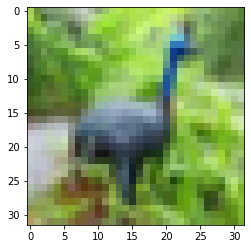

horse


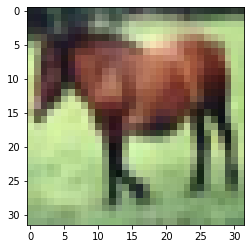

ship


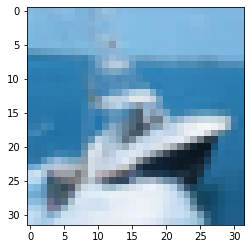

cat


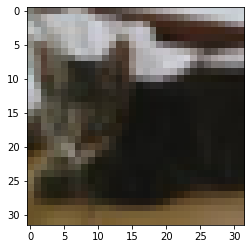

In [ ]:
# loading the dataset and unpack to train and test dictionaries
train, test = tf.keras.datasets.cifar10.load_data()


# label names list
label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


# printing some example images with their respective labels decoded to category names
for i in range(10):
    # looking through entries of the dict
    image = train[0][i]
    # print label names according to their indicies
    print(label_names[int(train[1][i])])    
    # print images
    plt.imshow(image)
    plt.show()

Model definition. Quite similar to lasts exercises model.

In [ ]:
from tensorflow.keras.layers import Layer

class Model(tf.keras.Model):

    def __init__(self):
    
        # 3 conv/pool blocks with 2 conv layers each. 2 dense hidden layers.

        # init super class
        super(Model, self).__init__()

        # define layers
        self.conv_layer_1 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='tanh', input_shape=(32,32,3))
        self.conv_layer_1_2 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='tanh')
        self.max_pool_layer_1 = tf.keras.layers.MaxPool2D()

        self.conv_layer_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation=None)
        self.conv_layer_2_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation=None)
        self.norm_layer_2 = tf.keras.layers.BatchNormalization()
        self.tanh_layer_2 = tf.keras.activations.tanh
        self.relu_layer_2 = tf.keras.activations.relu
        self.max_pool_layer_2 = tf.keras.layers.MaxPool2D()

        self.conv_layer_3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation=None)
        self.conv_layer_3_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation=None)
        self.norm_layer_3 = tf.keras.layers.BatchNormalization()
        self.relu_layer_3 = tf.keras.activations.relu
        self.tanh_layer_3 = tf.keras.activations.tanh
        self.max_pool_layer_3 = tf.keras.layers.MaxPool2D()
        
        self.mlp_input = tf.keras.layers.GlobalAveragePooling2D()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=64, activation=tf.keras.activations.tanh)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=32, activation=tf.keras.activations.tanh)
        self.output_layer = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)

    @tf.function
    def call(self, x, training=True):

        x = self.conv_layer_1(x)
        x = self.conv_layer_1_2(x)
        x = self.max_pool_layer_1(x)
        
        x = self.conv_layer_2(x)
        x = self.conv_layer_2_2(x)
        x = self.norm_layer_2(x, training)
        # x = self.relu_layer_2(x)
        x = self.tanh_layer_2(x) # better performance than relu in this case
        x = self.max_pool_layer_2(x)
        
        x = self.conv_layer_3(x)
        x = self.conv_layer_3_2(x)
        x = self.norm_layer_3(x, training)
        # x = self.relu_layer_3(x)
        x = self.tanh_layer_3(x)
        x = self.max_pool_layer_3(x)       
        
        x = self.mlp_input(x)
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.output_layer(x)
        
        return x

Processing images and doing some preparations.

*   normalize images between (0,1)
*   one_hot encode labels
*   shuffle
*   cache
*   batch
*   prefetch



In [ ]:
def prepare_data(images, labels):
    # normalizing
    images = images/255.0 # input normalization
    labels = tf.one_hot(labels, 10)
    return images, labels


# unpacking 
train_images, train_labels = train
test_images, test_labels = test

# converting images from uint8 to float for processing
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# convert numpy arrays to tf.datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))


# run processing steps
train_dataset = train_dataset.shuffle(buffer_size=10)
test_dataset = test_dataset.shuffle(buffer_size=10)


train_dataset = train_dataset.map(prepare_data, num_parallel_calls=4)
test_dataset = test_dataset.map(prepare_data, num_parallel_calls=4)


train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

train_dataset = train_dataset.batch(4)
test_dataset = test_dataset.batch(4)

train_dataset = train_dataset.prefetch(1)
test_dataset = test_dataset.prefetch(1)



Training the model.


Number of Epochs: 30
Epoch:___0

Estimated training time: 88 mins.

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           multiple                  448       
_________________________________________________________________
conv2d_37 (Conv2D)           multiple                  2320      
_________________________________________________________________
max_pooling2d_18 (MaxPooling multiple                  0         
_________________________________________________________________
conv2d_38 (Conv2D)           multiple                  4640      
_________________________________________________________________
conv2d_39 (Conv2D)           multiple                  9248      
_________________________________________________________________
batch_normalization_12 (Batc multiple                  128       
________________________________________________________

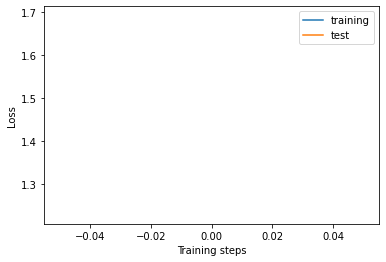

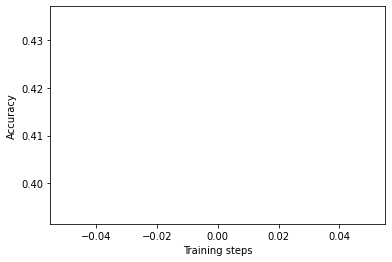

Epoch:___1


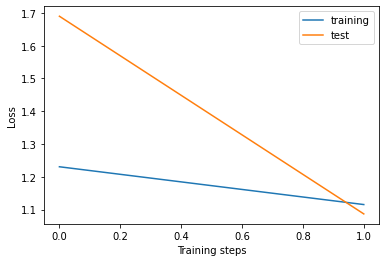

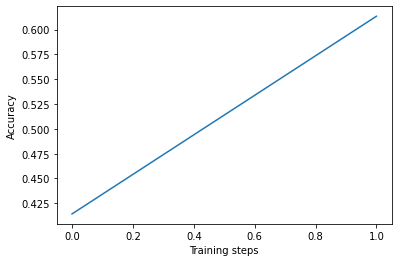

Epoch:___2


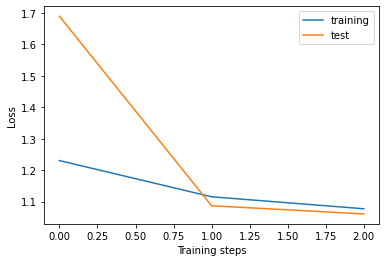

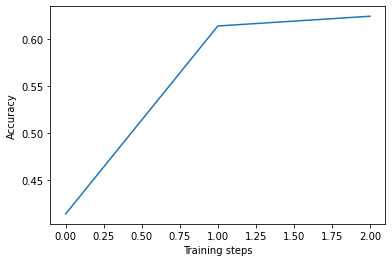

Epoch:___3


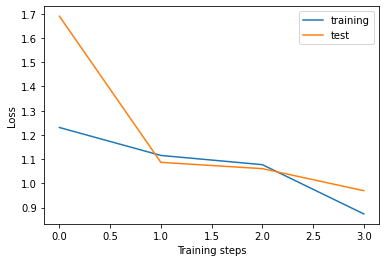

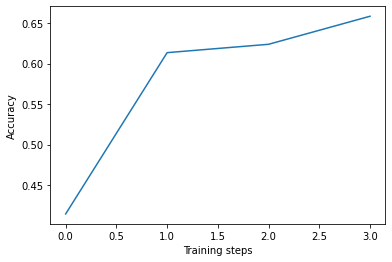

Epoch:___4


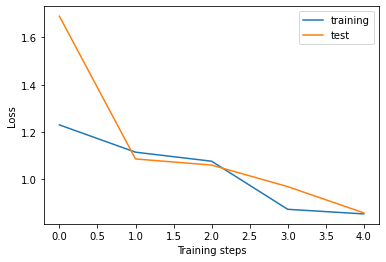

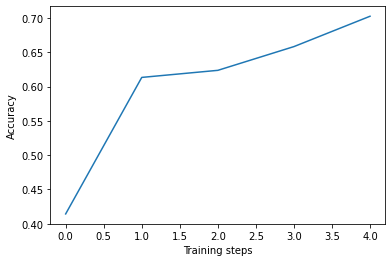

Epoch:___5


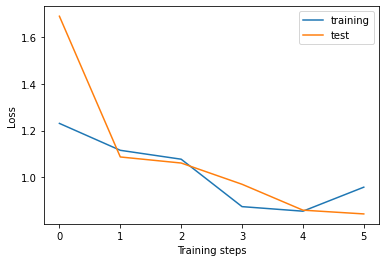

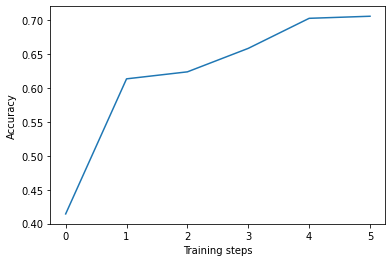

Epoch:___6


In [ ]:

tf.keras.backend.set_floatx('float32')

# hyperparameters
num_epochs = 30
learning_rate = 0.001
running_average_factor = 0.95

# init lists for visualization
train_losses = []
test_losses = []
test_accuracies = []

# init model
model = Model()



# init loss
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()

# init optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# taking time for time estimation
start = time.time()

print("")
print("Number of Epochs: " + str(num_epochs))

# helper methods
def train_step(model, input, target, loss_function, optimizer, training=True):
    with tf.GradientTape() as tape:
        prediction = model(input, training)
        # Debug
        #print('target shape: ' + str(target.shape))
        #print('target: ' + str(target))
        #print('prediction shape: ' + str(prediction.shape))
        #print('prediction: ' + str(prediction))
        # reshape target to match prediction shape
        target = tf.reshape(target, [4, 10])
        #print('new target shape: ' + str(target.shape))
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def test(model, test_data, loss_function, training=False):
    # test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input, training)
        # reshape target to match prediction shape
        target = tf.reshape(target, [4, 10])
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy


# train for number of epochs
for epoch in range(num_epochs):
    print('Epoch:___' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    running_average = 0
    for (data, target) in train_dataset:
        train_loss = train_step(model, data, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    if epoch == 0:
        end = time.time()
        end = end - start
        end = end * num_epochs - 2
        print("")
        print("Estimated training time: " + str(int(end / 60)) + " mins.")
        print("")
        model.summary()
        
    # plot loss and accury over epochs
    plt.figure()
    line1, = plt.plot(train_losses)
    line2, = plt.plot(test_losses)
    plt.xlabel("Training steps")
    plt.ylabel("Loss")
    plt.legend((line1,line2),("training","test"))
    plt.show()

    plt.figure()
    line1, = plt.plot(test_accuracies)
    plt.xlabel("Training steps")
    plt.ylabel("Accuracy")
    plt.show()


end = time.time()
print("")
print("Time elapsed: " + str(int((end - start)/60)) + " mins.")
print("")


Visualizing training results and accuracy.

In [ ]:

# plot loss and accury over epochs
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()